In [1]:
# tell jupyter where pyspark is
import findspark
findspark.init()
import xgboost as xgb

In [2]:
# Import useful stuff
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Models and support
from pyspark.sql.functions import col, avg
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.classification import MultilayerPerceptronClassifier

In [3]:
# Build a SparkSession; 
spark = SparkSession\
    .builder\
    .appName("Final Project")\
    .getOrCreate()

In [4]:
# Load preprocessed dataset 
df = spark.read.csv("data/Preprocessed_data_VIF.csv",inferSchema =True,header=True)
df = df.drop('_c0')
n_features = len(df.columns) - 1 

In [5]:
# Create a feature vector from the data
ignore = ['loan_status']
assembler = VectorAssembler(
    inputCols=[x for x in df.columns if x not in ignore],
    outputCol='features')

df = assembler.transform(df)
df = df.select(['loan_status','features'])

In [6]:
# Let's first split into a test and training set
(trainingData, testData) = df.randomSplit([0.8, 0.2])

In [7]:
# Now let's create all our models (Logistic Regression, GBT, Linear SVC, and MLP)
lr = LogisticRegression(maxIter=10, regParam=0.1, elasticNetParam=0.8,\
                        labelCol = 'loan_status', featuresCol = 'features')

dt = DecisionTreeClassifier(labelCol='loan_status', featuresCol="features")

rf = RandomForestClassifier(numTrees=10,\
                            labelCol="loan_status", featuresCol="features")

gbt = GBTClassifier(maxIter=10,\
                    labelCol = 'loan_status', featuresCol = 'features')

lsvc = LinearSVC(maxIter=10, regParam=0.1,\
                 labelCol = 'loan_status', featuresCol = 'features')

mlp = MultilayerPerceptronClassifier(maxIter=100, layers=[n_features, 5, 4, 2], blockSize=128,seed=1234,\
                                     labelCol = 'loan_status', featuresCol = 'features')

In [8]:
# Train all the models
lr_model = lr.fit(trainingData)
print('Logistic Regression training complete')

dt_model = dt.fit(trainingData)
print('Decision Tree training complete')

rf_model = rf.fit(trainingData)
print('Random Forest training complete')

gbt_model = gbt.fit(trainingData)
print('Gradient Boosted training complete')

lsvc_model = lsvc.fit(trainingData)
print('Linear SVC training complete')

mlp_model = mlp.fit(trainingData)
print('Multi-layer Perceptron training complete')

Logistic Regression training complete
Decision Tree training complete
Random Forest training complete
Gradient Boosted training complete
Linear SVC training complete
Multi-layer Perceptron training complete


In [9]:
# Make predictions with all the models
lr_predictions = lr_model.transform(testData)
dt_predictions = dt_model.transform(testData)
rf_predictions = rf_model.transform(testData)
gbt_predictions = gbt_model.transform(testData)
lsvc_predictions = lsvc_model.transform(testData)
mlp_predictions = mlp_model.transform(testData)

In [10]:
# Compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol='loan_status', predictionCol="prediction", metricName="accuracy")

lr_accuracy = evaluator.evaluate(lr_predictions)
print("Logistic Regression Test Error = %g" % (1.0 - lr_accuracy))

dt_accuracy = evaluator.evaluate(dt_predictions)
print("Decision Tree Test Error = %g" % (1.0 - dt_accuracy))

rf_accuracy = evaluator.evaluate(rf_predictions)
print("Random Forest Test Error = %g" % (1.0 - rf_accuracy))

gbt_accuracy = evaluator.evaluate(gbt_predictions)
print("Gradient Boosted Test Error = %g" % (1.0 - gbt_accuracy))

lsvc_accuracy = evaluator.evaluate(lsvc_predictions)
print("Linear SVC Test Error = %g" % (1.0 - lsvc_accuracy))

mlp_accuracy = evaluator.evaluate(mlp_predictions)
print("Multi-layer Perceptron Test Error = %g" % (1.0 - mlp_accuracy))

Logistic Regression Test Error = 0.0754192
Decision Tree Test Error = 0.0431028
Random Forest Test Error = 0.0484563
Gradient Boosted Test Error = 0.0428095
Linear SVC Test Error = 0.0596644
Multi-layer Perceptron Test Error = 0.0757798


In [11]:
# Compute f1 score
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol='loan_status', predictionCol="prediction", metricName="f1")

lr_f1 = f1_evaluator.evaluate(lr_predictions)
print("Logistic Regression F1 Score = %g" % lr_f1)

dt_f1 = f1_evaluator.evaluate(dt_predictions)
print("Decision Tree F1 Score = %g" % dt_f1)

rf_f1 = f1_evaluator.evaluate(rf_predictions)
print("Random Forest F1 Score = %g" % rf_f1)

gbt_f1 = f1_evaluator.evaluate(gbt_predictions)
print("Gradient Boosted F1 Score = %g" % gbt_f1)

lsvc_f1 = f1_evaluator.evaluate(lsvc_predictions)
print("Linear SVC F1 Score = %g" % lsvc_f1)

mlp_f1 = f1_evaluator.evaluate(mlp_predictions)
print("Multi-layer Perceptron F1 Score = %g" % mlp_f1)

Logistic Regression F1 Score = 0.888707
Decision Tree F1 Score = 0.951027
Random Forest F1 Score = 0.940776
Gradient Boosted F1 Score = 0.951253
Linear SVC F1 Score = 0.922115
Multi-layer Perceptron F1 Score = 0.887822


In [12]:
# Compute AUC score
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Compute auc score
auc_evaluator = BinaryClassificationEvaluator(
    labelCol='loan_status', rawPredictionCol="prediction", metricName="areaUnderROC")

lr_auc = auc_evaluator.evaluate(lr_predictions)
print("Logistic Regression AUC Score = %g" % lr_auc)

dt_auc = auc_evaluator.evaluate(dt_predictions)
print("Decision Tree AUC Score = %g" % dt_auc)

rf_auc = auc_evaluator.evaluate(rf_predictions)
print("Random Forest AUC Score = %g" % rf_auc)

gbt_auc = auc_evaluator.evaluate(gbt_predictions)
print("Gradient Boosted AUC Score = %g" % gbt_auc)

lsvc_auc = auc_evaluator.evaluate(lsvc_predictions)
print("Linear SVC AUC Score = %g" % lsvc_auc)

mlp_auc = auc_evaluator.evaluate(mlp_predictions)
print("Multi-layer Perceptron AUC Score = %g" % mlp_auc)

Logistic Regression AUC Score = 0.502379
Decision Tree AUC Score = 0.742812
Random Forest AUC Score = 0.680282
Gradient Boosted AUC Score = 0.742415
Linear SVC AUC Score = 0.607589
Multi-layer Perceptron AUC Score = 0.5


In [13]:
# Feature importances (only for tree models)
dt_features = dt_model.featureImportances
rf_features = rf_model.featureImportances
gbt_features = gbt_model.featureImportances

In [14]:
# Getting our features for visualization
features_df = spark.read.csv("data/Preprocessed_data_VIF.csv",inferSchema =True,header=True)
features_df = features_df.drop('_c0', 'loan_status')
feature_list = features_df.columns
print(feature_list)

['term', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'addr_state', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'pub_rec', 'revol_bal', 'initial_list_status', 'out_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'application_type']


In [15]:
# Plotting feature importance
def f_importances(coef, names, title):
    plt.figure(figsize=(10,10))
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.title(title)

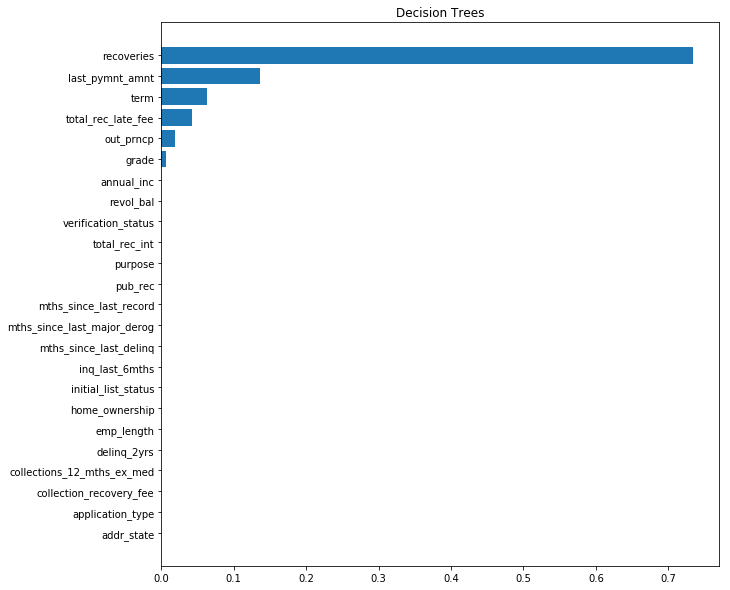

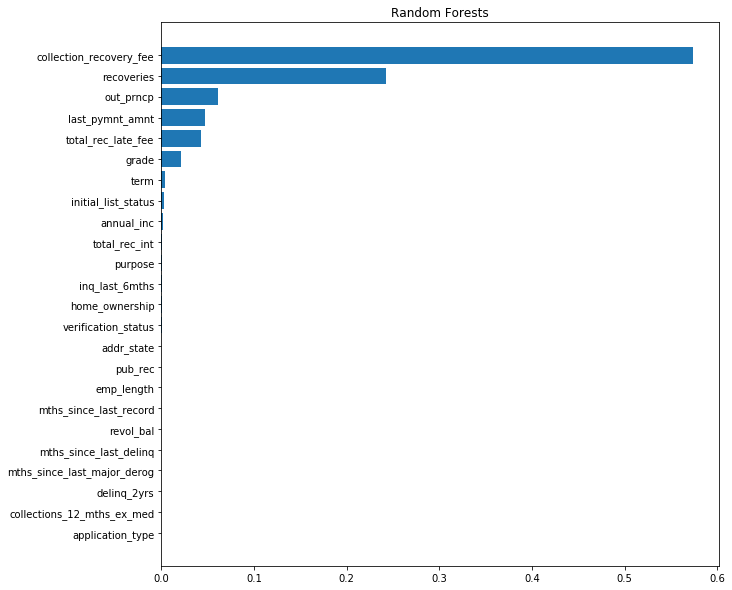

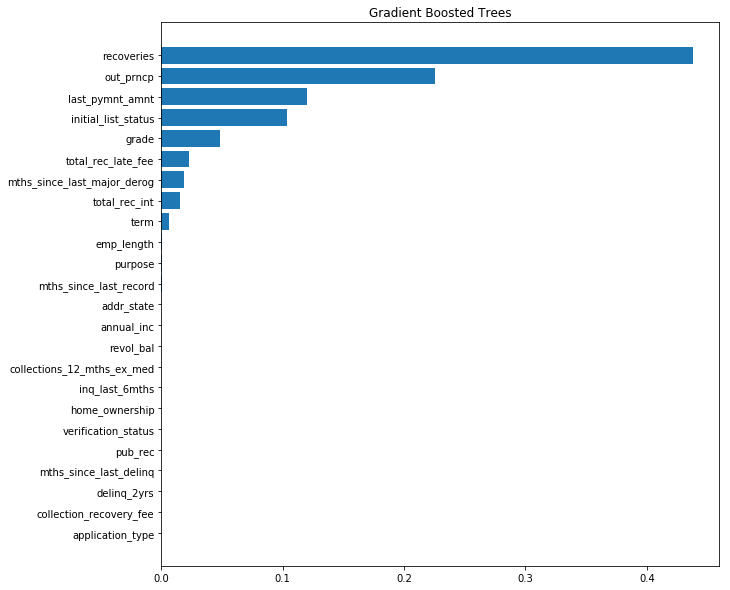

In [16]:
plt.figure(figsize=(50,20))
f_importances(dt_features, feature_list, 'Decision Trees')
f_importances(rf_features, feature_list, 'Random Forests')
f_importances(gbt_features, feature_list, 'Gradient Boosted Trees')